### **1. Carregamento e União dos Dados**

Nesta primeira etapa, vamos unificar todas as tabelas do projeto em uma única tabela mestra. Isso é crucial para que possamos trabalhar com todos os dados relevantes (reviews, clientes, produtos e pedidos) em um só lugar, o que facilita a análise e a preparação para o modelo.

Usaremos a biblioteca **Pandas** para ler os arquivos CSV e a função `pd.merge()` para unir os dataframes, garantindo que as informações de clientes, produtos, pedidos e reviews fiquem em um único lugar.

Após a união, salvaremos a nova tabela em um arquivo CSV. Isso evita que tenhamos que carregar e unir os dados repetidamente em cada execução, economizando tempo. O arquivo será salvo na pasta `archive_final`, garantindo que o seu projeto fique bem organizado.

In [3]:
import pandas as pd
import os

# 1. Carregar os datasets (ajuste os caminhos se necessário)
df_notas = pd.read_csv('/content/projeto/archives/olist_order_reviews_dataset.csv')
df_pedidos = pd.read_csv('/content/projeto/archives/olist_orders_dataset.csv')
df_itens_pedidos = pd.read_csv('/content/projeto/archives/olist_order_items_dataset.csv')
df_produtos = pd.read_csv('/content/projeto/archives/olist_products_dataset.csv')
df_clientes = pd.read_csv('/content/projeto/archives/olist_customers_dataset.csv')
df_tranducao = pd.read_csv('/content/projeto/archives/product_category_name_translation.csv')

# 2. Realizar as junções sequenciais para criar a tabela mestra
df_mestra = pd.merge(df_notas, df_pedidos, on='order_id', how='left')
df_mestra = pd.merge(df_mestra, df_clientes, on='customer_id', how='left')
df_mestra = pd.merge(df_mestra, df_itens_pedidos, on='order_id', how='left')
df_mestra = pd.merge(df_mestra, df_produtos, on='product_id', how='left')
df_mestra = pd.merge(df_mestra, df_tranducao, on='product_category_name', how='left')

# 3. Criar a pasta 'archive_final' se ela não existir
pasta_destino = 'archive_final'
if not os.path.exists(pasta_destino):
    os.makedirs(pasta_destino)

# 4. Definir o caminho completo para o arquivo de destino
caminho_completo = os.path.join(pasta_destino, 'tabela_mestra.csv')

# 5. Salvar a tabela mestra no novo local
df_mestra.to_csv(caminho_completo, index=False)

print(f'Tabela mestra salva com sucesso em {caminho_completo}')

Tabela mestra salva com sucesso em archive_final/tabela_mestra.csv


### **2. Pré-processamento e Criação da Variável Alvo**

Nesta etapa, vamos preparar a nossa tabela mestra para o treinamento do modelo. O principal objetivo é criar a variável alvo (`sentimento_review`), que o modelo usará para aprender a classificar.

O processo seguirá estes passos:
1.  **Criação da Variável Alvo:** A coluna `review_score` (nota da review) será usada para classificar o sentimento. Reviews com nota 4 ou 5 serão classificadas como **positivas** (valor `1`), e reviews com nota 1 ou 2 como **negativas** (valor `0`). As reviews com nota 3 serão removidas para garantir que o modelo aprenda com exemplos claros de sentimentos.
2.  **Limpeza do Texto:** A coluna de comentários (`review_comment_message`) terá seus valores ausentes (`NaN`) substituídos por strings vazias (`''`). Em seguida, o texto será convertido para letras minúsculas e toda a pontuação será removida, facilitando o processamento pelo modelo.


In [22]:
import pandas as pd

# 1. Carregar a tabela mestra
df_mestra = pd.read_csv('/content/projeto/archive_final/tabela_mestra.csv')

# 2. Criar a variável alvo 'sentimento_review' e remover as reviews neutras
df_mestra_limpa = df_mestra.dropna(subset=['review_score']).copy()
df_mestra_limpa.loc[:, 'sentimento_review'] = df_mestra_limpa['review_score'].apply(
    lambda x: 1 if x >= 4 else (0 if x <= 2 else None)
)

# 3. Limpeza dos dados de texto
# Substitua os valores NaN na coluna original por uma string vazia
df_mestra_limpa.loc[:, 'review_comment_message'] = df_mestra_limpa['review_comment_message'].fillna('')

# Crie a nova coluna 'review_comment_message_limpo' a partir da coluna limpa
# Crie a nova coluna com o texto limpo
df_mestra_limpa.loc[:, 'review_comment_message_limpo'] = (
    df_mestra_limpa['review_comment_message']
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True) # Este é o código que você já tem
)

print('Amostra de comentários limpos:')
print(df_mestra_limpa[['review_comment_message', 'review_comment_message_limpo']].head())
# Verifica a contagem de valores nulos na coluna após a limpeza
print('Valores nulos na coluna review_comment_message:', df_mestra_limpa['review_comment_message'].isnull().sum())




Amostra de comentários limpos:
                  review_comment_message          review_comment_message_limpo
0                                                                             
1                                                                             
2                                                                             
3                                                                             
4  Recebi bem antes do prazo estipulado.  recebi bem antes do prazo estipulado
Valores nulos na coluna review_comment_message: 0


### **3. Engenharia de Features: Vetorização do Texto**

Nesta fase, vamos transformar as palavras dos comentários em um formato numérico que o nosso modelo de Machine Learning possa entender.

Para isso, usaremos o **`CountVectorizer`** para aplicar a técnica **Bag of Words**. O `CountVectorizer` irá:
1.  Criar um vocabulário com as 5.000 palavras mais frequentes dos nossos comentários.
2.  Converter cada review em um vetor numérico, onde cada número representa a contagem de uma palavra no vocabulário.

Com essa etapa, teremos a nossa matriz de features (`X`) e a nossa variável alvo (`y`), prontas para serem usadas no treinamento do modelo.

In [25]:
# Mude a importação
from sklearn.feature_extraction.text import TfidfVectorizer

# Substitua o CountVectorizer pelo TfidfVectorizer
# max_features ainda é útil para manter o vocabulário gerenciável
vectorizer = TfidfVectorizer(max_features=5000)

# O restante do código de vetorização e treinamento continua o mesmo
X = vectorizer.fit_transform(df_mestra_limpa['review_comment_message_limpo'])

y = df_mestra_limpa['sentimento_review']

# Verifique o formato da matriz de features (X) e do vetor alvo (y)
print('Formato da matriz de features (X):', X.shape)
print('Formato do vetor alvo (y):', y.shape)

# O restante do seu código de treino e avaliação não precisa de alteração.

Formato da matriz de features (X): (113131, 5000)
Formato do vetor alvo (y): (113131,)


### **4. Treinamento do Modelo de Classificação**

Agora que nossos dados estão prontos, vamos treiná-los. Para isso, usaremos o `train_test_split` para dividir os dados em conjuntos de treinamento e teste. Isso nos permite treinar o modelo com uma parte dos dados e avaliar seu desempenho em dados que ele nunca viu, garantindo que ele não simplesmente "decore" as respostas.

Em seguida, treinaremos o modelo com o classificador `MultinomialNB`, um algoritmo ideal para tarefas de classificação de texto devido à sua eficiência e bom desempenho.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

# Load the dataframe created in the previous step


# The features are the vectorized text
X = vectorizer.fit_transform(df_mestra_limpa['review_comment_message_limpo'])

# The target variable is the 'sentimento_review' column
# Make sure to drop any potential NaN values from y before using it
y = df_mestra_limpa['sentimento_review'].dropna()

# Now, we need to ensure X and y have the same number of rows.
# Filter X to match the cleaned y
X = X[y.index]

# Split the data into training and testing sets
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Naive Bayes classifier
modelo = MultinomialNB()
modelo.fit(X_treino, y_treino)

# Make predictions on the test set
y_previsao = modelo.predict(X_teste)

print('O modelo foi treinado com sucesso!')


O modelo foi treinado com sucesso!


### **5. Avaliação do Modelo e Matriz de Confusão**

Após o treinamento, o modelo precisa ser avaliado para entender se ele está fazendo previsões precisas. Nesta etapa, vamos usar três métricas essenciais:
1.  **Acurácia (`accuracy_score`)**: A porcentagem de previsões corretas que o modelo fez.
2.  **Relatório de Classificação (`classification_report`)**: Fornece métricas mais detalhadas como precisão, recall e f1-score para cada classe (`0` e `1`).
3.  **Matriz de Confusão (`confusion_matrix`)**: Uma tabela que mostra o número de acertos e erros do modelo, permitindo visualizar onde ele acertou e onde errou.

Essas métricas nos darão uma visão clara do desempenho do nosso modelo.

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calcule a acurácia do modelo
acuracia = accuracy_score(y_teste, y_previsao)
print(f'Acurácia do modelo: {acuracia:.2f}\n')

# Mostre a Matriz de Confusão
print('Matriz de Confusão:')
print(confusion_matrix(y_teste, y_previsao))

# Mostre o Relatório de Classificação
print('\nRelatório de Classificação:')
print(classification_report(y_teste, y_previsao))



Acurácia do modelo: 0.92

Matriz de Confusão:
[[ 2198  1473]
 [  238 16822]]

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.90      0.60      0.72      3671
         1.0       0.92      0.99      0.95     17060

    accuracy                           0.92     20731
   macro avg       0.91      0.79      0.84     20731
weighted avg       0.92      0.92      0.91     20731



### **6. Visualização da Matriz de Confusão**

A matriz de confusão é uma ferramenta poderosa para entender o desempenho do modelo de forma visual. Embora tenhamos o relatório de classificação, a visualização da matriz nos ajuda a identificar facilmente onde o modelo acertou e onde errou.

O mapa de calor abaixo mostra:
* **Verdadeiros Positivos (Canto inferior direito)**: Reviews positivas que foram classificadas corretamente como positivas.
* **Verdadeiros Negativos (Canto superior esquerdo)**: Reviews negativas que foram classificadas corretamente como negativas.
* **Falsos Positivos (Canto superior direito)**: Reviews negativas que foram erroneamente classificadas como positivas.
* **Falsos Negativos (Canto inferior esquerdo)**: Reviews positivas que foram erroneamente classificadas como negativas.

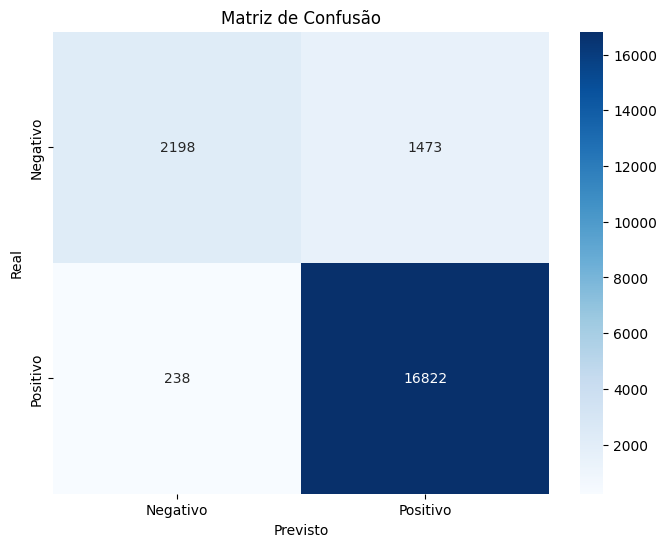

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Crie a matriz de confusão
cm = confusion_matrix(y_teste, y_previsao)

# Use Seaborn para plotar um mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

### **5. Bônus: Extraindo as Razões por Trás das Reviews**

Para o bônus, vamos além da simples classificação. Extrairemos as palavras que mais contribuem para o sentimento, permitindo identificar as razões que tornam uma review positiva ou negativa. Isso demonstra a capacidade de traduzir dados em *insights* de negócio.

Para esta análise, usaremos a **Regressão Logística** e o **TF-IDF**, que nos permitem encontrar as palavras com maior peso na classificação.

In [35]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# --- Carregar e preparar os dados reais ---
try:
    df_mestra = pd.read_csv('/content/projeto/archive_final/tabela_mestra.csv')
except FileNotFoundError:
    print("Erro: O arquivo 'tabela_mestra.csv' não foi encontrado.")
    print("Certifique-se de que a etapa de união dos dados foi executada corretamente.")
    exit()

# Criar a variável alvo e limpar os comentários
df_mestra.loc[:, 'sentimento_review'] = df_mestra['review_score'].apply(
    lambda x: 1 if x >= 4 else (0 if x <= 2 else None)
)
df_mestra.dropna(subset=['sentimento_review'], inplace=True)
df_mestra.loc[:, 'review_comment_message'] = df_mestra['review_comment_message'].fillna('')
df_mestra.loc[:, 'review_comment_message_limpo'] = (
    df_mestra['review_comment_message']
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True)
)

# Criar um subconjunto de dados para este exemplo
df_exemplo = df_mestra.sample(n=1000, random_state=42)

# Separar features (X) e alvo (y) do subconjunto
X = df_exemplo['review_comment_message_limpo']
y = df_exemplo['sentimento_review']

# --- Recriar o vetorizador e o modelo ---
vectorizer = TfidfVectorizer(max_features=5000)
X_vetorizado = vectorizer.fit_transform(X)

X_treino, X_teste, y_treino, y_teste = train_test_split(X_vetorizado, y, test_size=0.2, random_state=42)
modelo = LogisticRegression()
modelo.fit(X_treino, y_treino)

# --- Extração das palavras-chave ---
def get_top_n_words(model, feature_names, n):
    # Encontra as palavras mais importantes para a classe negativa (0)
    top_n_negative_idx = model.coef_[0].argsort()[:n]
    top_n_negative_words = [feature_names[i] for i in top_n_negative_idx]

    # Encontra as palavras mais importantes para a classe positiva (1)
    top_n_positive_idx = model.coef_[0].argsort()[-n:]
    top_n_positive_words = [feature_names[i] for i in top_n_positive_idx]

    return top_n_positive_words, top_n_negative_words

# Obtém as palavras do vocabulário
feature_names = vectorizer.get_feature_names_out()

# Extrai as 20 palavras mais relevantes para cada classe
top_positive_words, top_negative_words = get_top_n_words(modelo, feature_names, 20)

print("As 20 palavras que mais indicam uma review POSITIVA são:")
print(top_positive_words)

print("\nAs 20 palavras que mais indicam uma review NEGATIVA são:")
print(top_negative_words)


As 20 palavras que mais indicam uma review POSITIVA são:
['ok', 'certo', 'satisfeito', 'lindo', 'corretamente', 'parabéns', 'conforme', 'otimo', 'tudo', 'ótimo', 'qualidade', 'rápida', 'recomendo', 'ótima', 'bem', 'excelente', 'muito', 'bom', 'prazo', 'antes']

As 20 palavras que mais indicam uma review NEGATIVA são:
['não', 'recebi', 'um', 'de', 'veio', 'comprei', 'que', 'para', 'meu', 'na', 'nao', 'uma', 'só', 'com', 'péssimo', 'pedido', 'produtos', 'até', 'porém', 'estou']
